<a href="https://colab.research.google.com/github/S1ink/Colabs/blob/main/models/pc_transformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install open3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.9/214.9 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 80.5 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.5
    Uninstalling widgetsnbextension-3.6.5:
      Successfully uninstalled widgetsnbextension-3.6.5
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 2.3.7
    Uninstalling Werkzeug-2.3.7:
      Successfully uninstalled Werkzeug-2.3

In [2]:
import os
import shutil
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from scipy.spatial.transform import Rotation as R
from google.colab import files
from google.colab import drive

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils

import matplotlib.pyplot as plt
import open3d as o3d
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
content = files.upload()
pnames = list(content.keys())
for f in tqdm(pnames):
    shutil.unpack_archive(f)
    print("\nUnpacked {}!".format(f))

Saving 566215_266254_2023-09-18 11_53_31.878.tar.gz to 566215_266254_2023-09-18 11_53_31.878.tar.gz


100%|██████████| 1/1 [00:00<00:00, 65.05it/s]


Unpacked 566215_266254_2023-09-18 11_53_31.878.tar.gz!


In [3]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!ls -l

total 8
drwx------ 6 root root 4096 Sep 24 03:27 gdrive
drwxr-xr-x 1 root root 4096 Sep 21 13:49 sample_data


In [4]:
DS_BASE = "./gdrive/MyDrive/CSM/shoes-grass-dataset/"  # << SET THIS BASED ON IMPORTED FILES/CONNECTED GDRIVE FILE STRUCTURE
KEY_MAP_JSON = DS_BASE + "key_id_map.json"
META_JSON = DS_BASE + "meta.json"

def _annotation(fname):
    return DS_BASE + "ds0/ann/{}".format(fname)
def _source(fname):
    return DS_BASE + "ds0/pointcloud/{}".format(fname)

def _basename(path):
    return path.split("/")[-1].split(".")[0]


with open(KEY_MAP_JSON) as json_file:
    keymap = json.load(json_file)

with open(META_JSON) as json_file:
    meta = json.load(json_file)   # have the metadata for all the classes and colors

DEFAULT_LABEL = "none"
class_colors = dict()
ALL_LABELS = set()
class_colors[DEFAULT_LABEL] = "gray"
ALL_LABELS.add(DEFAULT_LABEL)
for c in meta["classes"]:
    label = c["title"]
    class_colors[label] = c["color"]
    ALL_LABELS.add(label)

# print(class_colors)

# print(meta)
# print(map)

point_sets = []         # extracted points for each point cloud
point_set_labels = []   # labels for each point in each point cloud
point_set_1hot = []     # 1hot array for each point

print(class_colors, ALL_LABELS)

annotations = glob(_annotation("*.pcd.json"))
for idx, a in enumerate(tqdm(annotations, "Files: ")):
    source = _source(_basename(a) + ".pcd")
    # print("\n", source)
    if(os.path.exists(source)):
        with open(a) as json_file:
           a_data = json.load(json_file)    # have the configuration for the bounds

        pcd = o3d.io.read_point_cloud(source)
        pc_data = np.asarray(pcd.points)    # have all the points as numpy array

        # print(a_data)
        # print(pc_data.shape)

        objects = a_data["objects"]
        figures = a_data["figures"]     # list of annotation volume
        label_bounds = []
        for f in figures:
            if f["geometryType"] != "cuboid_3d":
                continue
            objkey = f["objectKey"]
            geo = f["geometry"]
            class_label = next(i for i in objects if i["key"] == objkey)["classTitle"]  # find the first dictionary with a matching "key":objkey pair --> use that dictionaries class label

            # print(objkey, "\n", geo)
            # print("\n", class_label)

            # extract cuboid bbox data
            origin = np.array(list(geo["position"].values()))
            scale = np.array(list(geo["dimensions"].values())) / 2  # divide by 2 to get distance from center along each direction
            rotation = np.array(list(geo["rotation"].values()))     # rotation about x, y, z
            r = R.from_rotvec(rotation)     # convert to rotation matrix
            units = np.array([
                r.apply([1, 0, 0]),     # rotate unit x, y, z vectors by the cuboid's rotation so we can compare them to each point's offset from the center
                r.apply([0, 1, 0]),
                r.apply([0, 0, 1])
            ])

            label_bounds.append((origin, scale, units, class_label))    # append the center, lengths, unit directions, and class label

        # print(label_bounds)

        set_labels = []
        LABELS = list(ALL_LABELS)
        for i, p in enumerate(tqdm(pc_data, "Point Cloud[{}]: ".format(idx))):
            valid = False
            for l in label_bounds:

                v = p - l[0];
                d = np.array([
                    np.abs(np.dot(l[2][0], v)),
                    np.abs(np.dot(l[2][1], v)),
                    np.abs(np.dot(l[2][2], v))
                ])

                if (d <= l[1]).all():
                    valid = True
                    set_labels.append(l[3])
                    break
            if not valid:
                set_labels.append(DEFAULT_LABEL)

        set_1hot = [LABELS.index(label) for label in set_labels]
        set_1hot = tf.keras.utils.to_categorical(set_1hot, num_classes=len(ALL_LABELS))
        # print(set_1hot)

        # print(set_labels)
        point_sets.append(pc_data)
        point_set_labels.append(set_labels)
        point_set_1hot.append(set_1hot)

# print(point_sets, point_set_labels)
for i in tqdm(range(len(point_sets))):
    print(np.array(point_sets[i]).shape, np.array(point_set_1hot[i]).shape, np.array(point_set_labels[i]).shape)


{'none': 'gray', 'Shoe': '#50E3C2'} {'Shoe', 'none'}


100%|██████████| 13/13 [00:00<00:00, 130.74it/s]

(26005, 3) (26005, 2) (26005,)
(22696, 3) (22696, 2) (22696,)
(14028, 3) (14028, 2) (14028,)
(30738, 3) (30738, 2) (30738,)
(37981, 3) (37981, 2) (37981,)
(26588, 3) (26588, 2) (26588,)
(27960, 3) (27960, 2) (27960,)
(53990, 3) (53990, 2) (53990,)
(28928, 3) (28928, 2) (28928,)
(14749, 3) (14749, 2) (14749,)
(27801, 3) (27801, 2) (27801,)
(37981, 3) (37981, 2) (37981,)
(22273, 3) (22273, 2) (22273,)


In [ ]:
def visualize_data(pc, labels):
    xm = np.min(pc[:,0])
    xM = np.max(pc[:,0])
    ym = np.min(pc[:,1])
    yM = np.max(pc[:,1])
    zm = np.min(pc[:,2])
    zM = np.max(pc[:,2])
    r = np.max([xM - xm, yM - ym, zM - zm])
    df = pd.DataFrame(
        data={
            "x": pc[:, 0],
            "y": pc[:, 1],
            "z": pc[:, 2],
            "label": labels
        }
    )
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection="3d")
    ax.set_xlim3d(left=xm, right=(xm + r))
    ax.set_ylim3d(bottom=ym, top=(ym + r))
    ax.set_zlim3d(bottom=zm, top=(zm + r))
    for label in ALL_LABELS:
        c_df = df[df["label"] == label]
        try:
            ax.scatter(
                c_df["x"], c_df["y"], c_df["z"], label=label, alpha=0.5, c=class_colors[label]
            )
        except IndexError:
            pass
    ax.legend()
    plt.show()

for i in tqdm(range(len(point_sets))):
    visualize_data(point_sets[i], point_set_labels[i])

In [ ]:
def visualize_rotate(points, labels):
    colors = [class_colors[label] for label in labels]
    x, y, z = np.array(points).T
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames=[]

    def rotate_z(x, y, z, theta):
        w = x+1j*y
        return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))
    fig = go.Figure(data=go.Scatter3d(
                        x=x, y=y, z=z,
                        mode='markers',
                        opacity=0.6,
                        marker=dict(
                            size=5,
                            color=colors
                        )
                    ),
                    layout=go.Layout(
                        updatemenus=[dict(type='buttons',
                                    showactive=False,
                                    y=1,
                                    x=0.8,
                                    xanchor='left',
                                    yanchor='bottom',
                                    pad=dict(t=45, r=10),
                                    buttons=[dict(label='Play',
                                                    method='animate',
                                                    args=[None, dict(frame=dict(duration=50, redraw=True),
                                                                    transition=dict(duration=0),
                                                                    fromcurrent=True,
                                                                    mode='immediate'
                                                                    )]
                                                    )
                                            ]
                                    )
                                ],
                        scene_aspectmode='data'
                    ),
                    frames=frames
            )
    return fig

# for i, point_set in enumerate(tqdm(point_sets)):
#     visualize_rotate(point_set, point_set_labels[i]).show()
visualize_rotate(point_sets[10], point_set_labels[10]).show()


In [ ]:
LABEL_POINT_PATH = _annotation("all_labels/")

for i, ls in enumerate(tqdm(point_set_labels)):
    f = LABEL_POINT_PATH + _basename(annotations[i]) + ".txt"
    np.array(ls).tofile(f, sep=',', format='%s')


In [5]:
STATIC_COUNT = 25000

for index in tqdm(range(len(point_sets))):
    current_point_cloud = point_sets[index]
    current_label_cloud = point_set_1hot[index]
    current_labels = point_set_labels[index]
    num_points = len(current_point_cloud)
    # Randomly sampling respective indices.
    sampled_indices = None
    if(num_points < STATIC_COUNT):
        n = STATIC_COUNT // num_points
        sampled_indices = [i for i in range(num_points)]*n + random.sample(list(range(num_points)), STATIC_COUNT % num_points)
    else:
        sampled_indices = random.sample(list(range(num_points)), STATIC_COUNT)
    # Sampling points corresponding to sampled indices.
    sampled_point_cloud = np.array([current_point_cloud[i] for i in sampled_indices])
    # Sampling corresponding one-hot encoded labels.
    sampled_label_cloud = np.array([current_label_cloud[i] for i in sampled_indices])
    # Sampling corresponding labels for visualization.
    sampled_labels = np.array([current_labels[i] for i in sampled_indices])
    # Normalizing sampled point cloud.
    norm_point_cloud = sampled_point_cloud - np.mean(sampled_point_cloud, axis=0)
    norm_point_cloud /= np.max(np.linalg.norm(norm_point_cloud, axis=1))
    point_sets[index] = norm_point_cloud
    point_set_1hot[index] = sampled_label_cloud
    point_set_labels[index] = sampled_labels

point_sets = np.array(point_sets)
point_set_1hot = np.array(point_set_1hot)
point_set_labels = np.array(point_set_labels)

100%|██████████| 13/13 [00:00<00:00, 13.18it/s]


In [ ]:
for i in tqdm(range(len(point_sets))):
    print(point_sets[i].shape, point_set_1hot[i].shape, point_set_labels[i].shape)

visualize_rotate(point_sets[10], point_set_labels[10])

In [6]:
BATCH_SIZE = 5
VAL_SPLIT = 0.2

def load_data(point_cloud_batch, label_cloud_batch):
    point_cloud_batch.set_shape([STATIC_COUNT, 3])
    label_cloud_batch.set_shape([STATIC_COUNT, len(ALL_LABELS)])
    return point_cloud_batch, label_cloud_batch

def generate_dataset(point_clouds, label_clouds, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((point_clouds, label_clouds))
    dataset = dataset.shuffle(BATCH_SIZE) if is_training else dataset
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size=BATCH_SIZE)
    # dataset = (
    #     dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    #     if is_training
    #     else dataset
    # )
    return dataset

split_index = int(len(point_sets) * (1 - VAL_SPLIT))
train_point_clouds = point_sets[:split_index]
train_label_cloud = point_set_1hot[:split_index]
total_training_examples = len(train_point_clouds)

val_point_clouds = point_sets[split_index:]
val_label_cloud = point_set_1hot[split_index:]

print("Num train point clouds:", len(train_point_clouds))
print("Num train point cloud labels:", len(train_label_cloud))
print("Num val point clouds:", len(val_point_clouds))
print("Num val point cloud labels:", len(val_label_cloud))

train_dataset = generate_dataset(train_point_clouds, train_label_cloud)
val_dataset = generate_dataset(val_point_clouds, val_label_cloud, is_training=False)

print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)

Num train point clouds: 10
Num train point cloud labels: 10
Num val point clouds: 3
Num val point cloud labels: 3
Train Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, 25000, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 25000, 2), dtype=tf.float32, name=None))>
Validation Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, 25000, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 25000, 2), dtype=tf.float32, name=None))>


In [7]:
def conv_block(x: tf.Tensor, filters: int, name: str) -> tf.Tensor:
    x = layers.Conv1D(filters, kernel_size=1, padding="valid", name=f"{name}_conv")(x)
    x = layers.BatchNormalization(momentum=0.0, name=f"{name}_batch_norm")(x)
    return layers.Activation("relu", name=f"{name}_relu")(x)


def mlp_block(x: tf.Tensor, filters: int, name: str) -> tf.Tensor:
    x = layers.Dense(filters, name=f"{name}_dense")(x)
    x = layers.BatchNormalization(momentum=0.0, name=f"{name}_batch_norm")(x)
    return layers.Activation("relu", name=f"{name}_relu")(x)

class OrthogonalRegularizer(keras.regularizers.Regularizer):
    """Reference: https://keras.io/examples/vision/pointnet/#build-a-model"""

    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.identity = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.identity))

    def get_config(self):
        # config = super().get_config()
        # config.update({"num_features": self.num_features, "l2reg_strength": self.l2reg})
        # return config
        return {"num_features": self.num_features, "l2reg_strength": self.l2reg}

def transformation_net(inputs: tf.Tensor, num_features: int, name: str) -> tf.Tensor:
    """
    Reference: https://keras.io/examples/vision/pointnet/#build-a-model.

    The `filters` values come from the original paper:
    https://arxiv.org/abs/1612.00593.
    """
    x = conv_block(inputs, filters=64, name=f"{name}_1")
    x = conv_block(x, filters=128, name=f"{name}_2")
    x = conv_block(x, filters=1024, name=f"{name}_3")
    x = layers.GlobalMaxPooling1D()(x)
    x = mlp_block(x, filters=512, name=f"{name}_1_1")
    x = mlp_block(x, filters=256, name=f"{name}_2_1")
    return layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=keras.initializers.Constant(np.eye(num_features).flatten()),
        activity_regularizer=OrthogonalRegularizer(num_features),
        name=f"{name}_final",
    )(x)


def transformation_block(inputs: tf.Tensor, num_features: int, name: str) -> tf.Tensor:
    transformed_features = transformation_net(inputs, num_features, name=name)
    transformed_features = layers.Reshape((num_features, num_features))(
        transformed_features
    )
    return layers.Dot(axes=(2, 1), name=f"{name}_mm")([inputs, transformed_features])

def get_shape_segmentation_model(num_points: int, num_classes: int) -> keras.Model:
    input_points = keras.Input(shape=(None, 3))

    # PointNet Classification Network.
    transformed_inputs = transformation_block(
        input_points, num_features=3, name="input_transformation_block"
    )
    features_64 = conv_block(transformed_inputs, filters=64, name="features_64")
    features_128_1 = conv_block(features_64, filters=128, name="features_128_1")
    features_128_2 = conv_block(features_128_1, filters=128, name="features_128_2")
    transformed_features = transformation_block(
        features_128_2, num_features=128, name="transformed_features"
    )
    features_512 = conv_block(transformed_features, filters=512, name="features_512")
    features_2048 = conv_block(features_512, filters=2048, name="pre_maxpool_block")
    global_features = layers.MaxPool1D(pool_size=num_points, name="global_features")(
        features_2048
    )
    global_features = tf.tile(global_features, [1, num_points, 1])

    # Segmentation head.
    segmentation_input = layers.Concatenate(name="segmentation_input")(
        [
            features_64,
            features_128_1,
            features_128_2,
            transformed_features,
            features_512,
            global_features,
        ]
    )
    segmentation_features = conv_block(
        segmentation_input, filters=128, name="segmentation_features"
    )
    outputs = layers.Conv1D(
        num_classes, kernel_size=1, activation="softmax", name="segmentation_head"
    )(segmentation_features)
    return keras.Model(input_points, outputs)


In [8]:
x, y = next(iter(train_dataset))

num_points = x.shape[1]
num_classes = y.shape[-1]

segmentation_model = get_shape_segmentation_model(num_points, num_classes)
segmentation_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 3)]            0         []                            
                                                                                                  
 input_transformation_block  (None, None, 64)             256       ['input_1[0][0]']             
 _1_conv (Conv1D)                                                                                 
                                                                                                  
 input_transformation_block  (None, None, 64)             256       ['input_transformation_block_1
 _1_batch_norm (BatchNormal                                         _conv[0][0]']                 
 ization)                                                                                     

Total training steps: 100.


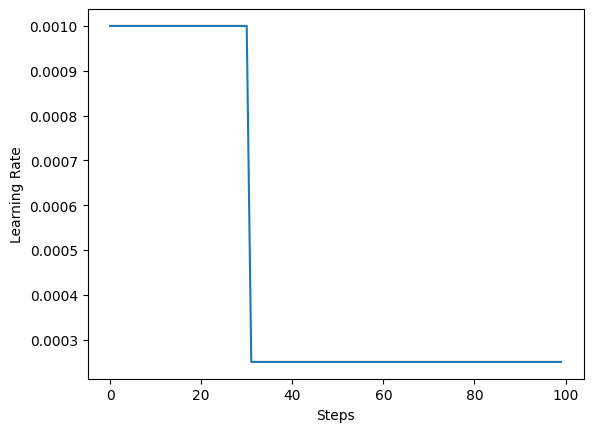

In [9]:
INITIAL_LEARNING_RATE = 0.001
EPOCHS = 50

training_step_size = total_training_examples // BATCH_SIZE
total_training_steps = training_step_size * EPOCHS
print(f"Total training steps: {total_training_steps}.")

lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[training_step_size * 15, training_step_size * 15],
    values=[INITIAL_LEARNING_RATE, INITIAL_LEARNING_RATE * 0.5, INITIAL_LEARNING_RATE * 0.25],
)

steps = tf.range(total_training_steps, dtype=tf.int32)
lrs = [lr_schedule(step) for step in steps]

plt.plot(lrs)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show()

In [ ]:
def run_experiment(epochs):

    segmentation_model = get_shape_segmentation_model(num_points, num_classes)
    segmentation_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = segmentation_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=[checkpoint_callback],
    )

    segmentation_model.load_weights(checkpoint_filepath)
    return segmentation_model, history


segmentation_model, history = run_experiment(epochs=EPOCHS)

Epoch 1/50
2/2 [==============================] - 171s 86s/step - loss: 3.5394 - accuracy: 0.5622 - val_loss: 396.7584 - val_accuracy: 0.0563
Epoch 2/50
2/2 [==============================] - 138s 70s/step - loss: 5.1747 - accuracy: 0.4457 - val_loss: 16299.2197 - val_accuracy: 0.6438
Epoch 3/50
2/2 [==============================] - 141s 71s/step - loss: 2.9653 - accuracy: 0.5889 - val_loss: 4040.9250 - val_accuracy: 0.0563
Epoch 4/50
2/2 [==============================] - 138s 68s/step - loss: 2.5791 - accuracy: 0.6300 - val_loss: 35.4116 - val_accuracy: 0.3615
Epoch 5/50
2/2 [==============================] - 143s 81s/step - loss: 2.9489 - accuracy: 0.6005 - val_loss: 202.8583 - val_accuracy: 0.3506
Epoch 6/50
2/2 [==============================] - 144s 75s/step - loss: 1.8408 - accuracy: 0.8518 - val_loss: 5.3178 - val_accuracy: 0.9437


In [3]:
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs
